In [47]:
import numpy as np
import time
import pickle
import os
import matplotlib.pyplot as plt
import warnings
import pandas as pd

warnings.filterwarnings('ignore')

In [48]:
print("----------------Reading the Data-------------------------")
PATH = os.getcwd()
os.chdir('Alphabets/')

X_train = pd.read_csv('train.csv', sep=',', header=None, index_col=False)
X_test = pd.read_csv('test.csv', sep=',', header=None, index_col=False)
np.random.shuffle(X_train.to_numpy())
train_class = X_train[X_train.columns[-1]]
test_actual_class = X_test[X_test.columns[-1]]

X_train = X_train.drop(X_train.columns[-1], axis=1)
X_test = X_test.drop(X_test.columns[-1], axis=1)

print("----------------Data Reading completed-------------------")

os.chdir('../')

X_train = X_train/255
X_test = X_test/255

m = X_train.shape[0] # Number of Training Samples

X_valid = X_train.iloc[(int(0.85*m)):]
valid_class = train_class[(int(0.85*m)):]
X_train = X_train.iloc[0:int(0.85*m)]
train_class = train_class[0:int(0.85*m)]


m = X_train.shape[0] # Number of Training Samples
n = X_train.shape[1] # Number of input features

print("The total number of training samples = {}".format(m))
print("The total number of validation samples = {}".format(X_valid.shape[0]))


print("The number of features = {}".format(n))

----------------Reading the Data-------------------------
----------------Data Reading completed-------------------
The total number of training samples = 11050
The total number of validation samples = 1950
The number of features = 784


In [49]:
#To get the one hot encoding of each label
print("--------Perform 1-hot encoding of class labels------------")

train_class_enc = pd.get_dummies(train_class).to_numpy()
valid_class_enc = pd.get_dummies(valid_class).to_numpy()
test_actual_class_enc = pd.get_dummies(test_actual_class).to_numpy()

--------Perform 1-hot encoding of class labels------------


In [50]:
#Add the intercept term to the data samples both in training and test dataset
X_train = np.hstack((np.ones((m,1)),X_train.to_numpy()))
X_valid = np.hstack((np.ones((X_valid.shape[0],1)), X_valid.to_numpy()))
X_test = np.hstack((np.ones((X_test.shape[0],1)),X_test.to_numpy()))

In [51]:
lr = 0.1
arch_test = [1,5,10,50,100]
arch = [arch_test[3]] #means one hidden layer with 2 perceptrons 
batch_size = 100 # Mini-Batch Size
r = np.max(train_class) + 1 # Default value of the number of classes = 26

In [52]:
#Mini-Batch formation
mini_batch = [(X_train[i:i+batch_size,:], train_class_enc[i:i+batch_size]) for i in range(0, m, batch_size)]
print("The number of mini-batches formed is = {}".format(len(mini_batch)))

The number of mini-batches formed is = 111


In [430]:
#Theta Initialization 
#np.random.seed(1)
def theta_init(arch=[50]):
    theta = []
    for i in range(len(arch)+1):
        if i == 0:
            dim0=n+1
            dim1=arch[i]
        elif (i == len(arch)):
            dim0=arch[i-1]+1
            dim1 = r
        else:
            dim0=arch[i-1]+1
            dim1= arch[i]
        theta.append(np.random.uniform(-0.07,0.07, (dim0,dim1)))
        #theta[i] = np.vstack((np.zeros((1,dim1)),theta[i]))

        #theta.append(0.01*(2*np.random.random((dim0, dim1))-1))
        #theta.append(np.zeros((dim0, dim1)))
        #theta.append(0.01*np.random.standard_normal((dim0, dim1)))
    return theta

In [318]:
def activation(x):
    return 1/(1+np.exp(-x))

In [319]:
def relu_act(x):
    return np.maximum(0.0, x)

In [320]:
def deriv_relu(x):
    #x[x<=0] = -0.01
    x[x<=0] = 0
    x[x>0] = 1
    return x

In [321]:
def leaky_relu_act(x):
    np.where(x > 0, x, x * 0.1) 
    return x

In [322]:
def deriv_leakyRelu(x):
    x[x<=0] = 0.1
    x[x>0] = 1
    return x

In [323]:
def softplus(x):
    return np.log(1+np.exp(x))

In [324]:
def deriv_softplus(x):
    return 1/(1+np.exp(-x))

In [417]:
def forward_prop(data, theta):
    fm = []
    fm.append(data)
    for l in range(len(theta)):
        if (l != len(theta)-1):
            #print("relu")
            fm.append(relu_act(np.dot(fm[l], theta[l])))
            fm[l+1]=np.hstack((np.ones((fm[l+1].shape[0],1)),fm[l+1]))
        else:
            fm.append(activation(np.dot(fm[l], theta[l])))
            #print("sigmoid output")
    return fm

In [418]:
theta = theta_init([100, 100])
print(theta[2].shape)
fm = forward_prop(X_train, theta)
cost_total(X_train, theta, train_class_enc, m)
len(fm)-1
for l in range(len(fm)-1, 0, -1):
    #print(l)
    a = (l==len(fm)-1)*1 + (l!= len(fm)-1)*2
    #print(a)
#cross_entropy_loss(X_train, theta, train_class_enc, m)
#fm = forward_prop(X_train, theta)

(101, 26)


In [327]:
def cost_total(X, theta, Y, m):
    fm = forward_prop(X, theta)
    cost = (1/(2*m))*np.sum((Y-fm[-1])**2)
    return cost

In [328]:
def cross_entropy_loss(X, theta, Y, m):
    fm = forward_prop(X, theta)
    cost = -(1/m)*(np.sum(((Y*np.log(fm[-1]))+((1-Y)*(np.log(1-fm[-1]))))))
    return cost

In [329]:
def calc_accuracy(data, theta, actual_class):
    pred_class = forward_prop(data, theta)
    test_pred_class = pred_class[-1]
    for i in range(len(test_pred_class)):
        test_pred_class[i][test_pred_class[i] == np.max(test_pred_class[i])] = 1
        test_pred_class[i][test_pred_class[i] != np.max(test_pred_class[i])] = 0


    test_acc = 0
    for i in range(len(actual_class)):
        if (np.array_equal(test_pred_class[i], actual_class[i])):
            test_acc+=1
    test_acc /= data.shape[0]

    #print("The Test Accuracy of the model = {}%".format(test_acc*100))
    return (test_acc*100)

In [330]:
epochs = []
train_accuracy = []
valid_accuracy =[]
test_accuracy = []
train_time = []

In [331]:

#print(theta[0].shape, theta[1].shape, theta[2].shape)

In [433]:
arch=[100,100]
lr=0.1
lr0=0.6
theta = theta_init(arch)
costs = []
epoch = 1
start = time.time()
#cost_init = cost_total(X_train, theta, train_class_enc, m) #Validation loss not giving much info
cost_init = cost_total(X_valid, theta, valid_class_enc, X_valid.shape[0]) #Validation loss not giving much info
costs.append(cost_init)
early_stop= 0
while(True):
    count = 0
    lr = lr0/(np.power(epoch, 1/4))
    #if(lr < 0.001): lr = 0.001
    print("learning rate = ", lr)

    print("Initial Cost on dataset for this epoch {} = {}".format(epoch, cost_init))

    for b in mini_batch:
        X_b = b[0]
        Y_b = b[1]
        fm = forward_prop(X_b, theta)
        #print(fm[1][:,-1])
        delta = [None]*len(fm)

        if (count % 60 == 0):
            print("Error on this batch = "+str(cost_total(X_b, theta, Y_b, batch_size)))
        #Backward Propagation
        #print(len(fm))
        for l in range(len(fm)-1, 0, -1):
            if (l == len(fm)-1):
                delta[l] = ((1/batch_size)*(Y_b - fm[l])*fm[l]*(1-fm[l]))
                #delta[l] = ((1/batch_size)*((Y_b/fm[l])-((1-Y_b)/(1-fm[l])))*fm[l]*(1-fm[l]))
                #print("delta for last layer=",delta[l].shape)
            else:
                #print(fm[l][0])
                if(l+1 == len(fm)-1):
                    delta[l]=np.dot(delta[l+1], theta[l].T)*deriv_relu(fm[l])
                else:
                    delta[l]=np.dot(delta[l+1][:,1:], theta[l].T)*deriv_relu(fm[l])
                    #print("delta for hidden layer=",np.mean(delta[l]))

        for t in range(len(theta)):
                if (t == len(theta)-1):
                    theta[t] += lr*np.dot(fm[t].T, delta[t+1]) 
                else:
                    theta[t] += lr*np.dot(fm[t].T, delta[t+1])[:,1:]
        
        count+=1
    epoch+=1 #Number of epochs
    #ite+=1

    #cost_final = cost_total(X_train, theta, train_class_enc, m)
    cost_final = cost_total(X_valid, theta, valid_class_enc, X_valid.shape[0])
    if(epoch%10==0): costs.append(cost_final)
    print("Cost on val dataset after {} epochs is = {}".format(epoch, cost_final))
    
    if ((cost_final-cost_init) > 0):
        early_stop +=1
    else:
        early_stop=0
        theta0=theta

    if (early_stop == 10):
        print("cost initial= {} , cost final={} , change in cost= {}".format(cost_init,cost_final, cost_final-cost_init))
        break

    cost_init = cost_final
    
    
epochs.append(epoch)
train_time.append(time.time()-start)
train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc))
valid_accuracy.append(calc_accuracy(X_valid, theta, valid_class_enc))
test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc))
print("\n------------------------------------------------------------------------------")
print("The stats for number of units in the hidden layer arch= {} are as below:".format(arch))
print("------------------------------------------------------------------------------")
print("The number of epochs = {:2.3f}".format(epochs[-1]))
print("The training time = {:2.3f}sec".format(train_time[-1]))
print("The training accuracy is = {:2.3f}%".format(train_accuracy[-1]))
print("The validation accuracy is = {:2.3f}%".format(valid_accuracy[-1]))
print("The test accuracy is = {:2.3f}%".format(test_accuracy[-1]))
print("------------------------------------------------------------------------------\n")

learning rate =  0.6
Initial Cost on dataset for this epoch 1 = 3.267907000423468
Error on this batch = 3.272362999771186
Error on this batch = 0.4999481390477945
Cost on val dataset after 2 epochs is = 0.49990819731675784
learning rate =  0.5045378491522288
Initial Cost on dataset for this epoch 2 = 0.49990819731675784
Error on this batch = 0.4998097869290041
Error on this batch = 0.4999347325178544
Cost on val dataset after 3 epochs is = 0.49988874902785857
learning rate =  0.4559014113909555
Initial Cost on dataset for this epoch 3 = 0.49988874902785857
Error on this batch = 0.499775290743025
Error on this batch = 0.49991678470720025
Cost on val dataset after 4 epochs is = 0.4998627940213585
learning rate =  0.42426406871192845
Initial Cost on dataset for this epoch 4 = 0.4998627940213585
Error on this batch = 0.4997301184712474
Error on this batch = 0.4998905689987869
Cost on val dataset after 5 epochs is = 0.4998253574941768
learning rate =  0.40124418298585324
Initial Cost on dat

Cost on val dataset after 36 epochs is = 0.23068647984115795
learning rate =  0.24494897427831783
Initial Cost on dataset for this epoch 36 = 0.23068647984115795
Error on this batch = 0.2012381992113918
Error on this batch = 0.21600055140683466
Cost on val dataset after 37 epochs is = 0.22604956019588743
learning rate =  0.2432768699032619
Initial Cost on dataset for this epoch 37 = 0.22604956019588743
Error on this batch = 0.19576639819812364
Error on this batch = 0.2114832192918935
Cost on val dataset after 38 epochs is = 0.2218395350914849
learning rate =  0.24166032278194638
Initial Cost on dataset for this epoch 38 = 0.2218395350914849
Error on this batch = 0.1907341049786173
Error on this batch = 0.2072344837850791
Cost on val dataset after 39 epochs is = 0.21794716224474112
learning rate =  0.24009609611534996
Initial Cost on dataset for this epoch 39 = 0.21794716224474112
Error on this batch = 0.18607359515016333
Error on this batch = 0.2032962838215315
Cost on val dataset afte

Cost on val dataset after 70 epochs is = 0.1651567018373064
learning rate =  0.2074324707851646
Initial Cost on dataset for this epoch 70 = 0.1651567018373064
Error on this batch = 0.1318874494334545
Error on this batch = 0.14276342855794927
Cost on val dataset after 71 epochs is = 0.16456788115477486
learning rate =  0.2066981850306836
Initial Cost on dataset for this epoch 71 = 0.16456788115477486
Error on this batch = 0.13128077597966936
Error on this batch = 0.14213026910338497
Cost on val dataset after 72 epochs is = 0.16399370760107035
learning rate =  0.20597671439071177
Initial Cost on dataset for this epoch 72 = 0.16399370760107035
Error on this batch = 0.13056700655989786
Error on this batch = 0.14171903144716155
Cost on val dataset after 73 epochs is = 0.16339845217852816
learning rate =  0.20526766182379289
Initial Cost on dataset for this epoch 73 = 0.16339845217852816
Error on this batch = 0.12989277862986065
Error on this batch = 0.14085257713769925
Cost on val dataset a

Cost on val dataset after 104 epochs is = 0.15350555298463975
learning rate =  0.18788534888296407
Initial Cost on dataset for this epoch 104 = 0.15350555298463975
Error on this batch = 0.12010005608930982
Error on this batch = 0.12645888978478304
Cost on val dataset after 105 epochs is = 0.15336970144651244
learning rate =  0.18743639621521535
Initial Cost on dataset for this epoch 105 = 0.15336970144651244
Error on this batch = 0.11981167187592918
Error on this batch = 0.12608465704171004
Cost on val dataset after 106 epochs is = 0.15322336002910442
learning rate =  0.18699275666415935
Initial Cost on dataset for this epoch 106 = 0.15322336002910442
Error on this batch = 0.11962855263679795
Error on this batch = 0.12582296274284932
Cost on val dataset after 107 epochs is = 0.15313458164848387
learning rate =  0.18655431811042028
Initial Cost on dataset for this epoch 107 = 0.15313458164848387
Error on this batch = 0.11944222845583041
Error on this batch = 0.12555219649319302
Cost on 

Cost on val dataset after 138 epochs is = 0.15176374633553438
learning rate =  0.1750578050454048
Initial Cost on dataset for this epoch 138 = 0.15176374633553438
Error on this batch = 0.11257788281208636
Error on this batch = 0.11453660632830151
Cost on val dataset after 139 epochs is = 0.15177139278429524
learning rate =  0.17474209987429748
Initial Cost on dataset for this epoch 139 = 0.15177139278429524
Error on this batch = 0.11243045193668241
Error on this batch = 0.11416733925519174
Cost on val dataset after 140 epochs is = 0.1517791924655252
learning rate =  0.17442922109046577
Initial Cost on dataset for this epoch 140 = 0.1517791924655252
Error on this batch = 0.11227202988557348
Error on this batch = 0.11376955439180118
Cost on val dataset after 141 epochs is = 0.15179463275569824
learning rate =  0.17411912347124506
Initial Cost on dataset for this epoch 141 = 0.15179463275569824
Error on this batch = 0.11209996024234144
Error on this batch = 0.11341673865477674
Cost on val

Cost on val dataset after 172 epochs is = 0.15187728691778143
learning rate =  0.16567963863996335
Initial Cost on dataset for this epoch 172 = 0.15187728691778143
Error on this batch = 0.10706141540474245
Error on this batch = 0.10819364995542366
Cost on val dataset after 173 epochs is = 0.15185208681526546
learning rate =  0.16543969646281814
Initial Cost on dataset for this epoch 173 = 0.15185208681526546
Error on this batch = 0.10689649776753866
Error on this batch = 0.10817334187816913
Cost on val dataset after 174 epochs is = 0.15180373242710457
learning rate =  0.1652014817392402
Initial Cost on dataset for this epoch 174 = 0.15180373242710457
Error on this batch = 0.10678880071549336
Error on this batch = 0.10816616887421131
Cost on val dataset after 175 epochs is = 0.15183209825100644
learning rate =  0.1649649722112678
Initial Cost on dataset for this epoch 175 = 0.15183209825100644
Error on this batch = 0.10672635039875467
Error on this batch = 0.1080274916788802
Cost on val

Cost on val dataset after 206 epochs is = 0.15190432722342423
learning rate =  0.15837420406902836
Initial Cost on dataset for this epoch 206 = 0.15190432722342423
Error on this batch = 0.10464904410821613
Error on this batch = 0.10736373121773657
Cost on val dataset after 207 epochs is = 0.15191246894635474
learning rate =  0.15818258338656938
Initial Cost on dataset for this epoch 207 = 0.15191246894635474
Error on this batch = 0.1046591074089304
Error on this batch = 0.10734998567842868
Cost on val dataset after 208 epochs is = 0.15200506008626738
learning rate =  0.157992116354378
Initial Cost on dataset for this epoch 208 = 0.15200506008626738
Error on this batch = 0.10467426431447589
Error on this batch = 0.10730430906437413
Cost on val dataset after 209 epochs is = 0.1521058434200051
learning rate =  0.15780279053039173
Initial Cost on dataset for this epoch 209 = 0.1521058434200051
Error on this batch = 0.10462230356701319
Error on this batch = 0.10727385207303888
Cost on val d

In [400]:
calc_accuracy(X_test, theta, test_actual_class_enc)
#calc_accuracy(X_test, theta0, test_actual_class_enc)


83.01538461538462

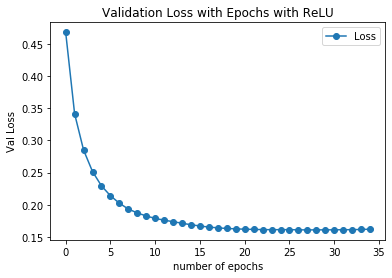

In [390]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Validation Loss with Epochs with ReLU")
x = np.arange(0,len(costs[1:]))
ax.plot(x, costs[1:], marker='o', label='Loss')
ax.set_xlabel("number of epochs")
ax.set_ylabel("Val Loss")

plt.legend()
#plt.savefig("plots/partd/relu_val_adapt_sqrt.png", dpi=1000, bbox_inches='tight')
#plt.show()

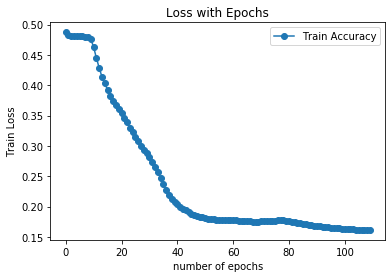

In [151]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Loss with Epochs")
x = np.arange(0,len(costs[1:]))
ax.plot(x, costs[1:], marker='o', label='Train Accuracy')
ax.set_xlabel("number of epochs")
ax.set_ylabel("Train Loss")data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYgAAAEWCAYAAAB8LwAVAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjMsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+AADFEAAAgAElEQVR4nO3de5zUZd3/8dd7D7ArLLscNmEXlEURQ1HRDVQ83aiBJyDrLk0LvSuzMvTnnYlmZZSm0m11l92m3pqaRuWBMCjuCrU8s4gKiMhZdgE56HLcZU+f3x/f7+IwzOzOws7O7M7n+XjMg5nre/rMd5b5zHVd3+v6ysxwzjnnomWlOgDnnHPpyROEc865mDxBOOeci8kThHPOuZg8QTjnnIvJE4RzzrmYPEF0UZIGSzJJOeHrv0ianMi6B3CsmyU9cDDxdlaSdkoa0sLyNZLO6ciY2kLSrZJ+24HHi/t3GC7/jaQfdVQ8rmWeINKUpL9KmhajfKKkjW39Mjez88zs4XaI6yxJlVH7vt3Mvnyw+45xrCskvdDe+21PZtbTzFbBwX+5he+3MUw6kY+S9os4tSL/Dg/28434YdN8ntZImtqG7eMmx3C/Rya6flflCSJ9PQxcLklR5V8AHjOzhhTE5JLv5TDpRD7WpzqoNFdkZj2BzwDflXRuqgPqKjxBpK+ZQF/g9OYCSb2BC4FHwtcXSFooabukdZJujbczSc9J+nL4PFvSTyRtkbQKuCBq3SslLZW0Q9IqSV8Ny3sAfwFKIn/dRv+ykjRB0hJJ1eFxPx6xbI2kb0l6S9I2Sb+XlNfWkxMed5akDyStkPSViGWjJFWE5+V9SXeH5XmSfitpaxjbfEmHxtj3lZKeiXi9XNIfI16vk3RC+NwkHSnpKuAy4NvheXkmYpcnHOz7DY+1RtJNkt6W9KGkhyL3Jekr4bn4IDw3JRHLjpH0t3DZ+5Jujth1N0mPhJ/3EknlEdvdKKkqXLZM0tkx4ioLz2dW+Pp+SZsilj8q6brw+XOSvhz+TdwLnBKer+qIXfaWNDs85quSjkjk/JhZBbAEOCHi2CWSnpS0WdJqSVMS2ZcLeIJIU2ZWA/wB+GJE8WeBd8zszfD1rnB5EcGX/NckTUpg918hSDQjgXKCX16RNoXLewFXAj+VdKKZ7QLOA9bH+3Ur6Sjgd8B1QDEwB3hGUreo9zEeKAOOA65IIOZoM4BKoCSM/3ZJY8NlPwd+bma9gCMIziPAZKAQGESQfK8GamLs+3ngdElZ4ZdsN+CU8P0NAXoCb0VuYGb3AY8Bd4Xn5aJ2fr/NLgPGhe/rKOCWMK6xwI/DYw0A1hKcIyQVAH8H/kpwvo4E/hGxzwnhukXALOCX4XbDgGuAT5hZQXjcNdEBmdlqYDvB3xPAGcDOiB8GZxKc08htlhKc/+YaU1HE4kuAHwC9gRXAbYmcGEknA8eG2xAmrGeAN4FS4GzgOknjEtmf8wSR7h4GPhPxK/GLYRkAZvacmS0ysyYze4vgi/nMBPb7WeBnZrbOzD4g+GLZy8xmm9lKCzwP/B8RNZlWfA6YbWZ/M7N64CdAPnBqxDr/bWbrw2M/Q8QvvkRIGgSMAW40s1ozewN4gI+SaT1wpKR+ZrbTzF6JKO8LHGlmjWa2wMy2R+8/7FPYEcZ1BjAXWC/paILz+y8za2pDyG15vyeHv8abHyujlv8y4nO7Dbg0LL8MeNDMXjezPcBNBL/OBxMk+41m9l/h+dphZq9G7PMFM5tjZo3Ao8DxYXkj0B0YLinXzNaYWXQ8zZ4HzpTUP3z9RPi6jOCHxptxtovlaTN7LWxGfYzW/z62SKoBXgZ+RVD7BvgEUGxm08ysLvxc7ydIQC4BniDSmJm9AGwBJoXV7FHA483LJY2W9GxYfd5G8IusXwK7LgHWRbxeG7lQ0nmSXgmbI6qB8xPcb/O+9+4v/CJdR/ALrtnGiOe7CX6Rt0UJ8IGZ7YgoWxtxjC8R/Lp+J2xGujAsf5Tgy36GpPWS7pKUG+cYzwNnESSI54HnCJLDfr+GE9CW9/uKmRVFPKKbV6I/t+ZmpOjzvhPYSnBOBgHxvthjxZcnKcfMVhDUBG8FNkmaofgd5pHn65/se77amlDb+vfRL1znP8MYmj/TwwmaQ/cmXOBmYL9mxRgaI/bTLJfgR0bG8ASR/h4h+GV8OTDXzN6PWPY4QZPAIDMrJGjTje7UjmUDwZdGs8Oan0jqDjxJ8Mv/0LDqPydiv61N/7ue4D9m8/4UHqsqgbgStR7oEzadNDus+RhmttzMLgU+BtwJPCGph5nVm9kPzGw4QY3mQvZtwovU/IV3evj8eVpPEB0xNXL059bcxBd93nsQ1JaqCJJK3EtxW2Jmj5vZaeG+jeB8xvI8wbk6K3z+AkEtr0POV1gjvBuoBb4eFq8DVkcl3AIzOz+BXb4HDI4qKyPqx1RX5wki/T0CnEPQbxB9mWoBwS/pWkmjgM8nuM8/AFMkDVTQ8R15aWA3gmaFzUCDpPOAT0Ysfx/oK6mwhX1fIOns8Nf5fwJ7gJcSjC2aFHQu732Y2bpwfz8Oy44jqDX8NtzgcknF4a/W5s7PJkn/JmmEpGyCNvN6IN4v2+eBfwPyzawS+BdBP0JfYGGcbd7nAL+I2+Ab4efWB/gO8Puw/HfAlZJOCJP87cCrZrYG+DMwQNJ1krpLKpA0urUDSRomaWy4v1qC/pqY58vMlofLLweeD5vu3gc+TfwE8T4wMKp/6mDdQXChQB7wGrAj7GjPV3BxxrGSPhGxflbU31f3sPz3wC3huc5SMJblIoKms4zhCSLNhf/BXwJ6ENQWIn0dmCZpB/A9PuqMbc39BE0tbwKvA09FHG8HMCXc14cESWdWxPJ3CL6MVoXV9n2aHMxsGcGXxC8ImscuAi4ys7oEY4t2KsEXz96HgjEglxL8wlsPPA1838z+Hm4zHlgiaSdBh/UlYad/f4L/4NuBpQRfXI/GOqiZvQvsJEgMhF94q4AXw7b6WP6XoL2+WtLMOOu0pvmqnshH5Bfa4wR9QqsImo1+FMb3d+C7BLW/DQSd2JeEy3YA5xJ8FhuB5QTJrzXdCb5wt4TbfYygbyOe54GtYQJvfi2Cv7FY5hFcdbRR0pYE4knEbIK/26+En9OFBH0YqwnexwMEFyo0u5R9/76am+KmEfy/eyHc313AZWa2uJ3i7BTkNwxyrnOQtAb4ckQidC6pvAbhnHMuJk8QzjnnYvImJuecczF5DcI551xMBzS9czrq16+fDR48ONVhOOdcp7JgwYItZlYca1mXSRCDBw+moqIi1WE451ynIinu4D9vYnLOOReTJwjnnHMxeYJwzjkXU5fpg3DOuQNVX19PZWUltbW1qQ4lafLy8hg4cCC5ufEmMN6fJwjnXMarrKykoKCAwYMHo/3u8tv5mRlbt26lsrKSsrKyhLfL+AQxc2EV0+cuY311DSVF+dwwbhiTRpa2vqFzrsuora3tsskBQBJ9+/Zl8+bNbdouoxPEzIVV3PTUImrqg8k5q6pruOmpRQCeJJzLMF01OTQ7kPeX0Z3U0+cu25scmtXUNzJ97rIUReScc+kjoxPE+upY96uPX+6cc8nSs2db77ybfBndxFRSlE9VjGRQUpSfgmicc51FpvRdZnQN4oZxw8jPzd6nLD83mxvGDUtRRM65dNfcd1lVXYPxUd/lzIXtedv1wJo1axg7dizHHXccZ599Nu+99x4Af/zjHzn22GM5/vjjOeOMMwBYsmQJo0aN4oQTTuC4445j+fLlB338jK5BNGf8G598iz0NTZR24V8CzrnE/OCZJby9fnvc5Qvfq6aucd9bc9fUN/LtJ97id6+9F3Ob4SW9+P5Fx7Q5lm9+85tMnjyZyZMn8+CDDzJlyhRmzpzJtGnTmDt3LqWlpVRXB7ddv/fee7n22mu57LLLqKuro7Ex3p1xE5fRNQgIksRFx5cwoDCPF6eO9eTgnGtRdHJorfxgvPzyy3z+858H4Atf+AIvvPACAGPGjOGKK67g/vvv35sITjnlFG6//XbuvPNO1q5dS37+wTeVZ3QNotmAwjw27dhDQ2MTOdkZnzOdy2it/dIfc8e8mH2XpUX5/P6rpyQrrH3ce++9vPrqq8yePZuTTjqJBQsW8PnPf57Ro0cze/Zszj//fH79618zduzYgzqOfxsC/QvzaGwytuysS3Uozrk015F9l6eeeiozZswA4LHHHuP0008HYOXKlYwePZpp06ZRXFzMunXrWLVqFUOGDGHKlClMnDiRt95666CP7zUIghoEwIZtNfQPnzvnXCzNzdDtfRXT7t27GThw4N7X119/Pb/4xS+48sormT59OsXFxTz00EMA3HDDDSxfvhwz4+yzz+b444/nzjvv5NFHHyU3N5f+/ftz8803H1Q84AkCgP69gra6DdtqGZniWJxz6W/SyNJ2769saordhzFv3rz9yp566qn9yqZOncrUqVPbNaakNjFJGi9pmaQVkuJGLunTkkxSefh6sKQaSW+Ej3uTGedHNYiuO5Ojc861VdJqEJKygXuAc4FKYL6kWWb2dtR6BcC1wKtRu1hpZickK75IRYfk0j0ni43bfAS1c841S2YNYhSwwsxWmVkdMAOYGGO9HwJ3Ain7+S6JAYV5XoNwLoOZWapDSKoDeX/JTBClwLqI15Vh2V6STgQGmdnsGNuXSVoo6XlJp8c6gKSrJFVIqmjrNLbR+hfmsdEThHMZKS8vj61bt3bZJNF8P4i8vLZdhJOyTmpJWcDdwBUxFm8ADjOzrZJOAmZKOsbM9hneaGb3AfcBlJeXH9QnO6Awn9dWf3Awu3DOdVIDBw6ksrKyzfdL6Eya7yjXFslMEFXAoIjXA8OyZgXAscBz4Tzl/YFZkiaYWQWwB8DMFkhaCRwFVCQr2AGFeby/vZamJiMrq2vPC++c21dubm6b7rSWKZLZxDQfGCqpTFI34BJgVvNCM9tmZv3MbLCZDQZeASaYWYWk4rCTG0lDgKHAqiTGyoDCPBqajC279iTzMM4512kkLUGYWQNwDTAXWAr8wcyWSJomaUIrm58BvCXpDeAJ4GozS2r7T//CYCyE90M451wgqX0QZjYHmBNV9r04654V8fxJ4MlkxhYtcizEcW1rpnPOuS7J52IKNU+x4TUI55wLeIII9TmkG92ys3wshHPOhTxBhLKyxKGF3X00tXPOhTxBRBjQK5/1XoNwzjnAE8Q+fDS1c859xBNEhAFhguiqw+2dc64tPEFE6F+YR11jEx/s8jvLOeecJ4gIfl8I55z7iCeICAN8NLVzzu3lCSLC3hrEdk8QzjnnCSJC357dycmSj4Vwzjk8QewjO0sc2svvLOecc+AJYj8+FsI55wKeIKJ4gnDOuYAniCgDwiYmHyznnMt0niCi9C/Mo6a+kW019akOxTnnUsoTRJTmsRDeUe2cy3SeIKL4jYOccy7gCSKKT7fhnHMBTxBRPlbQnSzhg+WccxnPE0SUnOwsPlbgg+Wcc84TRAz9C/PY6PMxOecynCeIGAYUeg3COeeSmiAkjZe0TNIKSVNbWO/TkkxSeUTZTeF2yySNS2ac0Xw0tXPOJTFBSMoG7gHOA4YDl0oaHmO9AuBa4NWIsuHAJcAxwHjgV+H+OsSAwjx27mlgR60PlnPOZa5k1iBGASvMbJWZ1QEzgIkx1vshcCcQ+ZN9IjDDzPaY2WpgRbi/DtHfbxzknHNJTRClwLqI15Vh2V6STgQGmdnstm4bbn+VpApJFZs3b26fqPGxEM45BynspJaUBdwN/OeB7sPM7jOzcjMrLy4ubrfY+vfy0dTOOZeTxH1XAYMiXg8My5oVAMcCz0kC6A/MkjQhgW2T6tAwQaz3wXLOuQyWzBrEfGCopDJJ3Qg6nWc1LzSzbWbWz8wGm9lg4BVggplVhOtdIqm7pDJgKPBaEmPdR7ecLPr17O41COdcRktaDcLMGiRdA8wFsoEHzWyJpGlAhZnNamHbJZL+ALwNNADfMLPGZMUai4+FcM5lumQ2MWFmc4A5UWXfi7PuWVGvbwNuS1pwrRhQmMfarbtTdXjnnEs5H0kdR1CD8D4I51zm8gQRR//CfLbXNrBrT0OqQ3HOuZTwBBFH81gIn7TPOZepPEHE4XeWc85lOk8QcfhoaudcpvMEEcehe0dTe0e1cy4zeYKIIy83mz49unkNwjmXsTxBtKB/L78vhHMuc3mCaIGPpnbOZTJPEC3o74PlnHMZzBNECwYU5vHh7npq6zt0GijnnEsLniBaMMDvLOecy2CeIFrgYyGcc5nME0QL9o6m3u79EM65zOMJogX9vQbhnMtgniBacEi3HArzc70PwjmXkTxBtMLHQjjnMpUniFb0L/TR1M65zOQJohVeg3DOZSpPEK3o3yufLTv3UNfQlOpQnHOuQ3mCaEXzWIj3/c5yzrkM4wmiFX6pq3MuU3mCaEVJUXOC8MFyzrnMktQEIWm8pGWSVkiaGmP51ZIWSXpD0guShoflgyXVhOVvSLo3mXG2pL/Px+Scy1A5ydqxpGzgHuBcoBKYL2mWmb0dsdrjZnZvuP4E4G5gfLhspZmdkKz4EtWzew4F3XO8ick5l3GSWYMYBawws1VmVgfMACZGrmBm2yNe9gAsifEcMB8L4ZzLRMlMEKXAuojXlWHZPiR9Q9JK4C5gSsSiMkkLJT0v6fRYB5B0laQKSRWbN29uz9j30b8wjw1+FZNzLsOkvJPazO4xsyOAG4FbwuINwGFmNhK4HnhcUq8Y295nZuVmVl5cXJy0GAcU5rHRO6mdcxkmmQmiChgU8XpgWBbPDGASgJntMbOt4fMFwErgqCTF2ar+hfls2rGH+kYfLOecyxzJTBDzgaGSyiR1Ay4BZkWuIGloxMsLgOVheXHYyY2kIcBQYFUSY23Rxm01mMFR3/kLY+6Yx8yFLeU555zrGlq9iknSEUClme2RdBZwHPCImVW3tJ2ZNUi6BpgLZAMPmtkSSdOACjObBVwj6RygHvgQmBxufgYwTVI90ARcbWYfHNhbPDgzF1Yxc+F6IOhBr6qu4aanFgEwaeR+XSrOOddlyKzlC4ckvQGUA4OBOcCfgGPM7PykR9cG5eXlVlFR0e77HXPHPKqq9+9/KC3K58WpY9v9eM4515EkLTCz8ljLEmliajKzBuBTwC/M7AZgQHsGmM7Wx0gOLZU751xXkUiCqJd0KUHzz5/DstzkhZReSory21TunHNdRSIJ4krgFOA2M1stqQx4NLlhpY8bxg0jPzd7n7L83GxuGDcsRRE551zHaLWTOpwaYwqApN5AgZndmezA0kVzR/SPZr/Nlp119O3Rje9eONw7qJ1zXV6rNQhJz0nqJakP8Dpwv6S7kx9a+pg0spQXbhxLt+wsPnPSQE8OzrmMkEgTU2E4Z9LFBJe3jgbOSW5Y6ScvN5vjBxXyyqqtqQ7FOec6RCIJIkfSAOCzfNRJnZFOHtKXxeu3s3NPQ6pDcc65pEskQUwjGOy20szmhyOblyc3rPQ0uqwvjU1GxZqUjNlzzrkO1WqCMLM/mtlxZva18PUqM/t08kNLPyceXkROlnhllScI51zXl0gn9UBJT0vaFD6elDSwI4JLN4d0y+H4QUW8utr7IZxzXV8iTUwPEUyyVxI+ngnLMtLosj4sqtzGLu+HcM51cYkkiGIze8jMGsLHb4Dk3XwhzY0e0peGJmPB2g9THYpzziVVIgliq6TLJWWHj8uBjG1jKT+8N9lZ8mYm51yXl0iC+A+CS1w3Etzp7TPAFUmMKa316J7DiNJCXvWOaudcF5fIVUxrzWyCmRWb2cfMbBKQkVcxNRs9pA9vVlZTU9eY6lCccy5pDvSOcte3axSdzMlD+lLfaLz+nvdDOOe6rgNNEGrXKDqZ8sN7kyV41afdcM51YQeaIFq+DV0XV5CXy7GlhT5gzjnXpcWd7lvSDmInAgEZf7eck4f05TcvrqG2vpG8qPtFOOdcVxC3BmFmBWbWK8ajwMxavY9EVze6rA91jU0sfK861aE451xSHGgTU8YrH9wHCR8P4ZzrsjxBHKDC/FyOKenl94dwznVZniAOwuiyvix8r5o9DT4ewjnX9SQ1QUgaL2mZpBWSpsZYfrWkRZLekPSCpOERy24Kt1smaVwy4zxQo8v6sKehiTfXbUt1KM451+7iJghJOyRtj/HYIWl7azuWlA3cA5wHDAcujUwAocfNbISZnQDcBdwdbjscuAQ4BhgP/CrcX1oZVRb0Q3gzk3OuKzrQq5h6JbDvUcCK8AZDdcAMYGLUMSITTQ8+uqx2IjDDzPaY2WpgRbi/tFJ0SDeO7t/LO6qdc11Swk1Mkj4m6bDmRwKblALrIl5XhmXR+/2GpJUENYgpbdz2KkkVkio2b96c6FtpV6PL+rBg7YfUNTSl5PjOOZcsidxRboKk5cBq4HlgDfCX9grAzO4xsyOAG4Fb2rjtfWZWbmblxcWpuUXFyUP6UlvfxFuVPh7COde1JFKD+CFwMvCumZUBZwOvJLBdFTAo4vXAsCyeGcCkA9w2ZUaV9QHg1dU+7YZzrmtJJEHUm9lWIEtSlpk9C5QnsN18YKikMkndCDqdZ0WuIGloxMsLgOXh81nAJZK6SyoDhgKvJXDMDtenRzeGHVrgHdXOuS4nkSkzqiX1BP4JPCZpE7CrtY3MrEHSNcBcIBt40MyWSJoGVJjZLOAaSecA9cCHwORw2yWS/gC8DTQA3zCztB1scPKQPvxxQSX1jU3kZvvQEudc1yCzlidmldQDqCWYpO8yoBB4LKxVpI3y8nKrqKhIybHnLNrA1x97nae+fionHtY7JTE459yBkLTAzGK2CrU0DuIeSWPMbJeZNZpZg5k9bGb/nW7JIdX29kP49N/OuS6kpfaQd4GfSFoj6S5JIzsqqM6mX8/ufKygOz/7+7uUTZ3NmDvmMXNhWvapO+dcwloaKPdzMzsFOBPYCjwo6R1J35d0VIdF2AnMXFjF1l117GlowoCq6hpuemqRJwnnXKfWao+qma01szvNbCRwKcGlqEuTHlknMn3uMhqb9u3LqalvZPrcZSmKyDnnDl4iA+VyJF0k6TGCAXLLgIuTHlknsr66pk3lzjnXGbR0y9FzCWoM5xOMQZgBXGVmrV7immlKivKpipEMSooy/s6szrlOrKUaxE3AS8DHzWyCmT3uySG2G8YNIz/qvtT5udncMG5YiiJyzrmDF7cGYWZjOzKQzmzSyGAewelz36GqupacLHH7p47dW+6cc52RD/ttJ5NGlvLi1LO54+IRNDQZA/sckuqQnHPuoHiCaGcTTyilIC+HR15em+pQnHPuoHiCaGf53bL595MG8dfFG9i0ozbV4Tjn3AHzBJEEl598GPWNxu9fW9f6ys45l6Y8QSTBkOKenD60H4+/9h4NjX6nOedc5+QJIkm+cPLhbNhWy9+Xbkp1KM45d0A8QSTJ2KM/RklhHr99xTurnXOdkyeIJMnJzuKykw/nhRVbWLl5Z6rDcc65NvMEkUSfLR9Ebra8FuGc65Q8QSRRcUF3zjt2AE8sqGR3XUOqw3HOuTbxBJFkXzzlcHbUNvCnN9anOhTnnGsTTxBJdtLhvTm6fwGPvryW1u7/7Zxz6cQTRJJJ4ounDObtDdt5/b0PUx2Oc84lzBNEB5h4QgkF3XN41Odncs51Ip4gOkCP7jl8+qSBzFm0kS0796Q6HOecS0hSE4Sk8ZKWSVohaWqM5ddLelvSW5L+IenwiGWNkt4IH7OSGWdHuPzkw6lrbGLsT56jbOpsxtwxj5kLq1IdlnPOxRX3hkEHS1I2cA9wLlAJzJc0y8zejlhtIVBuZrslfQ24C/hcuKzGzE5IVnwdbXHVNrIE22uDy12rqmu46alFAH5jIedcWkpmDWIUsMLMVplZHcE9rSdGrmBmz5rZ7vDlK8DAJMaTUtPnLqMp6iKmmvpGps9dlpqAnHOuFclMEKVA5HzXlWFZPF8C/hLxOk9ShaRXJE1KRoAdaX11TZvKnXMu1ZLWxNQWki4HyoEzI4oPN7MqSUOAeZIWmdnKqO2uAq4COOywwzos3gNRUpRPVYxkUFKUn4JonHOudcmsQVQBgyJeDwzL9iHpHOA7wAQz23uJj5lVhf+uAp4DRkZva2b3mVm5mZUXFxe3b/Tt7IZxw8jPzd6nrFtOFjeMG5aiiJxzrmXJTBDzgaGSyiR1Ay4B9rkaSdJI4NcEyWFTRHlvSd3D5/2AMUBk53anM2lkKT++eASlRfkIyM4Shfk5nDeif6pDc865mJLWxGRmDZKuAeYC2cCDZrZE0jSgwsxmAdOBnsAfJQG8Z2YTgI8Dv5bURJDE7oi6+qlTmjSydO8VS8+/u5nJD77G/zy3kuvOOSrFkTnn3P7UVeYHKi8vt4qKilSH0SZTfreQvy7eyF+uO50jinumOhznXAaStMDMymMt85HUKfTdC4eTl5vFd55e5BP5OefSjieIFCou6M5N53+cV1Z9wBMLKlMdjnPO7cMTRIp9rnwQ5Yf35vY5S/lgV12qw3HOub08QaRYVpa4/eIR7NzTwG2zl6Y6HOec28sTRBo46tACvnrGETz5eiUvrdiS6nCccw5Ik5HUDq4ZeyS/e20tX3jwNZqajJKifG4YN8wn8nPOpYwniDTx18Ub2VHbSGM4o5/P9uqcSzVvYkoT0+cuo66xaZ8yn+3VOZdKniDShM/26pxLN54g0kS8WV0P7ZXXwZE451zAE0SaiDXbK4AwttXUpyAi51ym8wSRJqJney0tyudrZx7Bll11fOXhCmrrG1MdonMuw/hVTGkkcrbXZsNLejFlxkKm/G4h/3P5SWRnKUXROecyjdcg0txFx5fw/QuH839vv88tMxf7pH7OuQ7jNYhO4IoxZWzeuYd7nl1JcUF3rj/X7x/hnEs+TxCdxLc+OYzNO/bw3/9YzsMvrWF7Tb2PtnbOJZU3MXUSkji5rA9Zgm019RgfjbaeuXC/W30759xB8wTRifzX35bTFNUF4aOtnXPJ4gmiE/HR1s65juQJohOJN9q6e24Wu+saOjga51xX5wmiE4k12jo3W9TWN/HZX7/Mhm1ek3DOtR9PEJ1IrNHW0z9zPA9eUc6aLbuZ+DnWyjUAABH6SURBVMsXeWNddarDdM51EeoqA6/Ky8utoqIi1WGkzLKNO/jSw/PZvGMPn/vEIP6xdBPrq2v8UljnXIskLTCz8ljLvAbRRQzrX8CfvjGGkqI8Hnl5LVXVNX4prHPuoCQ1QUgaL2mZpBWSpsZYfr2ktyW9Jekfkg6PWDZZ0vLwMTmZcXYVfXt2Z099037lfimsc+5AJC1BSMoG7gHOA4YDl0oaHrXaQqDczI4DngDuCrftA3wfGA2MAr4vqXeyYu1KNmyrjVnul8I659oqmTWIUcAKM1tlZnXADGBi5Apm9qyZ7Q5fvgIMDJ+PA/5mZh+Y2YfA34DxSYy1y4h3KWxebhZbdu7p4Gicc51ZMhNEKbAu4nVlWBbPl4C/tGVbSVdJqpBUsXnz5oMMt2uIdSlsTpaoa2ji3LufZ+bCKp8R1jmXkLSYrE/S5UA5cGZbtjOz+4D7ILiKKQmhdTrNVytNn7tsn6uYjinpxbeffIvrfv8Gs95cz+lD+/HAv1b7lU7OubiSmSCqgEERrweGZfuQdA7wHeBMM9sTse1ZUds+l5Qou6BYNx4CeOLqU3n4pTX8eM5S5r2zaW9585VOzds65xwkt4lpPjBUUpmkbsAlwKzIFSSNBH4NTDCzTRGL5gKflNQ77Jz+ZFjmDkJ2lviP08ro07Pbfsv8SifnXLSk1SDMrEHSNQRf7NnAg2a2RNI0oMLMZgHTgZ7AHyUBvGdmE8zsA0k/JEgyANPM7INkxZppNm2P3VldVV3D7roGDumWFi2PzrkU85HUGWjMHfOoinPZa6+8HC4ddRhfPHUw81d/sF9fhjdBOde1tDSS2n8qZqAbxg3jpqcWUVPfuLcsPzeLr5wxhJWbdvHAC6u575+rkNh7/wnvp3Au83iCyEDxrnRqLq+qrmHcT//Jzj37TiHe3E/hCcK5zOAJIkPFu9IJgllid+2JfX+JquoaHvjXKs4fMYCSonxmLqzyZijnuihPEC6mkqL8mP0UudniR7OX8qPZSxnc9xCqqmuobwzaobwZyrmuxWdzdTHFGpGdn5vN9M8cz7PfOosbxg2j8sOPkkOzmvpG7pr7zj5lMxdWMeaOeZRNnc2YO+b5zLLOdRJeg3AxtdZP8Y1/O5KfxBk3sb66lmtnLOSMocXsqqvnx3OW7e0Q91qGc52HX+bqDli8y2Xzc7Pp0T2bLTvr4m5bWpTPi1PH7n3tfRnOpYZf5uqSIvblstn8+OIRTDi+hLc3bOfCX7wQc9uq6hru/tu7HFPSi6oPdzN97jJqwntZeC3DufTgCcIdsNaaoY4tLaQ0Tmd3Tpb45bzle8dZRKupb+Suv76zT4LwWoZzHcubmFxSzVxYFbeWMe6Y/izduJ2Lf/VS3O0P73sIww4tAIxnl23ep1O8eT+eRJw7cN7E5FKmtVrGiYf1jlvLKMjL4ZiSXizbuIOVm3ftt7ymvpHv/WkxPbvnMKx/ARWrP+DmmYu9Q9y5duI1CJdyLdUymr/Yy6bOprW/VEHMdUqL8nhx6tn7HM9rGc4FvAbh0lprtQyIP3BvQGEev/z8ibz7/o69tYVoVdW1XPyrFznq0AJq6xuZs2gjdY0td4h7EnHOE4RLEy1N/QHxr5i6cfzRnHR4b046vDe/nLciZhLp0S2bnOws5i7ZyIe76/dbXlPfyC0zF1Pf2MTgfj1YumE7P56ztNWrqjyJuK7Om5hcp9HaF3JrTVVmxpCb5rTaVBVPnx7deOQ/RlFalM9zyzZx89OLW2wWSyTmRNdxLllaamLyBOG6lNa+bOMN7ispyuPxL5/M6q27uPKh+fstjxavv6P3Ibn8/JKR9OnRjYq1H3DHX96hNqyJwP5JJJH+l0TeV3uu49JDR32eniCcCyXyhRwviRQXdOeHE4+lqrqGH/757QOOIT83m38vH0hRfi4Pv7yGbTX7z5x7aK/uzJlyOod0y+Gvizbsc3VWrJgTeV/plow6Mul1tnXa8/NsjScI5yK0x3/OeEnkYwXd+dVlJ7JlZx1X/3ZB3BiKDsllW009B/Pfr1t2FmOO7Et+t2yefWfzPvE265WXw7XnHEVOlvjp396lumb/Pph+Pbvxq8tOIjdbvLhyC7/4xwr2NHxU68nLyeLm84/mvBElZGeJvy7ewLQ/v71PzSgvN4vvXzSc80eUADD7rfUx1/neRcO5YEQJsxetZ9oz+y+/fdIIPnViKZLa7Usy1evk5Wbxo4nHcuHxJTSZMeuN9dz6zJJ93nv3nCyuP/coTh9aTH1jE196eH7MqWqK8nO59pyh7Glo4p5nV7Cjdv8fF9HT2LTGE4RzbZTMJNL8H7ipyRhz5zw2bKvdb52iQ3L5f+ccxe66Ru786zv7LW82orSQ3XUNMceJdGbZWaIxzjD7LMGhvfLIkti4vTbmejlZYlCfQzAz1n1YE3OdbIlDe3XHgPe318Yc1Z8l6H1INwyo3l0Xcx0B3XOzaDKoi0isqSJg9R0XJL5+CwnCp/t2LoZJI0t5cepYVt9xAS9OHbtflX3SyFJ+fPEISovyEcGXfnTVPt6U6TeMGwZAVpa4cfzRMde59aJjmHzqYL521hGUFuXHjLG0KJ9nvnka//jPs+KuM6Awjze/90kqbjmH/r3yYq7Tr2c3fvul0Tx0xSdaPCc/nHgMP5hwTIvr3HLBx/nuhcNbXKe15VPOHsrXzjwi7vImg9OO7MfJQ/rGTSINTcaxpYUcN7Ao7jqNZpx6ZD9OO7Jf3ClfmgzGH9uf80f0j7uOAZNPGcyVYwa38K7g2+OHMfW8o1tc597LT+R/J5fTt0e3mMv798pj4XfP5e1p4ygpiv15lsT5WzgQfpmrcweotUtzExnfkcg68S7xbU40La1z4/ijKTwkF4Cp5x0dc51bLhjOaUP7AcQd1V5alM8XThkMwH3/XBV3nS+fPgSAB19YHXedL51W1uLy6889CoCnF1bFXWf6vx8PwCurtsZd5xeXjgRgwdoP467zk3A/L62Mv5/bPjUCgGff2Rx3nZvO/zgAf35zQ9x1vn7WkQA8+vLauOuMP3YAECTRWJ/V1POOpneYPL49LvbnGfl3cbC8BuFcErVWE0lknURqK+21Tmu1nvZap6OO01nXaa/P82B5H4Rzbh9+FVN6rNNRUtZJLWk88HMgG3jAzO6IWn4G8DPgOOASM3siYlkj0Dx3wntmNqGlY3mCcM65tkvJXEySsoF7gHOBSmC+pFlmFnkB+XvAFcC3YuyixsxOSFZ8zjnnWpbMTupRwAozWwUgaQYwEdibIMxsTbgs9deGOeec20cyO6lLgXURryvDskTlSaqQ9IqkSbFWkHRVuE7F5s2bDyZW55xzUdL5KqbDw3axzwM/k7TfhdFmdp+ZlZtZeXFxccdH6JxzXVgyE0QVMCji9cCwLCFmVhX+uwp4DhjZnsE555xrWTL7IOYDQyWVESSGSwhqA62S1BvYbWZ7JPUDxgB3tbTNggULtkhaexDx9gO2HMT2Ha2zxQsec0fpbDF3tniha8V8eLwNkn2Z6/kEl7FmAw+a2W2SpgEVZjZL0ieAp4HeQC2w0cyOkXQq8GugiaCW8zMz+9+kBRrEWhHvUq901NniBY+5o3S2mDtbvJA5MSd1qg0zmwPMiSr7XsTz+QRNT9HbvQSMSGZszjnnWpbOndTOOedSyBPER+5LdQBt1NniBY+5o3S2mDtbvJAhMXeZuZicc861L69BOOeci8kThHPOuZgyPkFIGi9pmaQVkqamOp5ESFojaZGkNySl5RS2kh6UtEnS4oiyPpL+Jml5+G/vVMYYLU7Mt0qqCs/1G+Gl22lB0iBJz0p6W9ISSdeG5Wl7nluIOZ3Pc56k1yS9Gcb8g7C8TNKr4XfH7yXFvg1cB2sh3t9IWh1xjludDDWj+yDCGWffJWLGWeDSqBln046kNUC5maXtQJ1wKvedwCNmdmxYdhfwgZndESbj3mZ2YyrjjBQn5luBnWb2k1TGFoukAcAAM3tdUgGwAJhEMENyWp7nFmL+LOl7ngX0MLOdknKBF4BrgeuBp8xshqR7gTfN7H9SGSu0GO/VwJ8jb6vQmkyvQeydcdbM6oDmGWfdQTKzfwIfRBVPBB4Onz9M8MWQNuLEnLbMbIOZvR4+3wEsJZgQM23Pcwsxpy0L7Axf5oYPA8YCzV+2aXOeW4i3zTI9QRzsjLOpYsD/SVog6apUB9MGh5rZhvD5RuDQVAbTBtdIeitsgkqb5ppIkgYTzFf2Kp3kPEfFDGl8niVlS3oD2AT8DVgJVJtZQ7hKWn13RMdrZs3n+LbwHP9UUvfW9pPpCaKzOs3MTgTOA74RNo10Kha0bXaG9s3/AY4ATgA2AP+V2nD2J6kn8CRwnZltj1yWruc5RsxpfZ7NrDG8gdlAgpaHo1McUoui45V0LHATQdyfAPoArTY7ZnqCOKgZZ1MlYqbbTQRzWY1KbUQJez9sg25ui96U4nhaZWbvh//ZmoD7SbNzHbYxPwk8ZmZPhcVpfZ5jxZzu57mZmVUDzwKnAEWSmqcrSsvvjoh4x4fNe2Zme4CHSOAcZ3qC2DvjbHgFwiXArBTH1CJJPcLOPST1AD4JLG55q7QxC5gcPp8M/CmFsSSk+Ys29CnS6FyHnZH/Cyw1s7sjFqXteY4Xc5qf52JJReHzfIKLWpYSfPF+Jlwtbc5znHjfifjRIIL+klbPcUZfxQSxZ5xNcUgtkjSEoNYAwWSLj6djzJJ+B5xFMMXw+8D3gZnAH4DDgLXAZ80sbTqF48R8FkGzhwFrgK9GtO+nlKTTgH8BiwhmPga4maBNPy3PcwsxX0r6nufjCDqhswl+VP/BzKaF/xdnEDTXLAQuD3+dp1QL8c4DigEBbwBXR3Rmx95XpicI55xzsWV6E5Nzzrk4PEE455yLyROEc865mDxBOOeci8kThHPOuZg8QTgXQdJzkpJ+M3pJUyQtlfRYso8VddxbJX2rI4/pOq+c1ldxziVCUk7E3Dyt+TpwjplVJjMm5w6G1yBcpyNpcPjr+/5wvvv/C0eM7lMDkNQvnBodSVdImqng/ghrJF0j6XpJCyW9IqlPxCG+EM6Xv1jSqHD7HuEkcq+F20yM2O+scBDSP2LEen24n8WSrgvL7gWGAH+R9P+i1s+WNF3S/HBSta+G5WdJ+qek2QruX3KvpKxw2aUK7g+yWNKdEfsaL+l1BfcFiIxteHieVkmaEvH+ZofrLpb0uYP5jFwXYWb+8EenegCDgQbghPD1HwhGsQI8R3CvDAhGRK8Jn18BrAAKCEaTbiMYSQrwU4JJ45q3vz98fgawOHx+e8QxigjuI9Ij3G8l0CdGnCcRjBjuAfQElgAjw2VrgH4xtrkKuCV83h2oAMoIRnTXEiSWbIIZRT8DlADvhe8pB5hHMI1CMcFMxWXhvvqE/94KvBTuux+wlWA66E83v+9wvcJUf87+SP3Dm5hcZ7XazN4Iny8gSBqtedaCexDskLQNeCYsXwQcF7He7yC4P4SkXuG8Np8EJkS03+cRTGUBwXTKsaayOA142sx2AUh6CjidYFqGeD4JHCepeY6fQmAoUAe8Zmarwn39Ltx/PfCcmW0Oyx8jSGyNwD/NbHX4XiLjm23BlBB7JG0imA58EfBfYQ3kz2b2rxZidBnCE4TrrCLnvGkE8sPnDXzUdJrXwjZNEa+b2Pf/QvT8M0Ywf82nzWxZ5AJJo4FdbYq8ZQK+aWZzo45zVpy4DkT0ucsxs3clnQicD/xI0j/MbNoB7t91Ed4H4bqaNQRNO/DRTJtt9TnYO7HcNjPbBswFvhnOhImkkQns51/AJEmHhDPvfiosa8lc4GvhlNhIOircFoJ5/cvCvofPEdxK8jXgzLC/JZtg0rvngVeAMySVhfvpE32gSJJKgN1m9ltgOnBiAu/PdXFeg3BdzU+APyi4097sA9xHraSFBG3z/xGW/ZBg1t+3wi/o1cCFLe3Egvsu/4bgSxzgATNrqXkJ4AGC5rLXw2S0mY9uZTkf+CVwJMFU00+bWZOC+04/S1D7mG1mfwIIz8FTYbybCKZ9jmcEMF1SE0Gz1ddaidNlAJ/N1blOIGxi+paZtZiUnGtP3sTknHMuJq9BOOeci8lrEM4552LyBOGccy4mTxDOOedi8gThnHMuJk8QzjnnYvr/Ma38PxFjPG4AAAAASUVORK5CYII=

plt.legend()
#plt.savefig("accuracy_HiddenUnit_val20per.png", dpi=1000, bbox_inches='tight')
plt.show()